## 内容：
基于transformer分类故障，再利用注意力权重做可解释。


## 数据：
CWRU： 正常 + 3种故障程度*（外圈+内圈+滚子） = 10种类别



In [1]:
import numpy as np
import tensorflow as tf
import scipy
import scipy.io as scio
from scipy import signal
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image

# import pywt
from tqdm import tqdm
from sklearn.manifold import TSNE
from collections import Counter
from glob import glob
import cv2

print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices("GPU"))
# print(tf.config.experimental.get_device_details())

2.10.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 全局设置

In [2]:
# print(plt.rcParams.keys())

plt.rcParams.update(
    {
        "font.family": "Times New Roman",  # monospace   "Times New Roman"  cursive
        "font.size": 10,
        "figure.dpi": 150,
        # dpi=150,显示得图片大小合适，保存时，设置更高dpi即可
        "axes.titlesize": 10,
        "axes.labelsize": 10,
        "legend.fontsize": 9,
        "legend.edgecolor": "0.5",
        "legend.fancybox": False,
        "legend.markerscale": 1.0,
        "legend.frameon": False,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "grid.alpha": 0.5,
        "grid.linestyle": "--",
        "savefig.dpi": 600,
    }
)


# 22-9-5
def get_date():
    now_time = list(time.localtime(time.time()))
    now_time = "_TIME-({0:4d}-{1:02d}-{2:02d})-({3:02d}-{4:02d}-{5:02d})_".format(
        now_time[0],
        now_time[1],
        now_time[2],
        now_time[3],
        now_time[4],
        now_time[5],
    )
    return now_time


now_time = get_date()
print(now_time)


Health_status = ["NC", "OF1", "IF1", "RF1", "OF2", "IF2", "RF2", "OF3", "IF3", "RF3"]


def normalF(x):
    mean = np.mean(x)
    std = np.std(x)
    new_x = (x - mean) / (std + 1e-6)
    return new_x


def scaleF(x):
    mi = np.min(x)
    ma = np.max(x)
    new_x = (x - mi) / (ma - mi + 1e-6)
    new_x = new_x * 2 - 1
    return new_x


BATCH_SIZE = 64
CWT_SCAL_NUM = 128

IMG_WIDTH = 256
IMG_HEIGHT = 64

SIGNAL_LENGTH = 2048

dta_R_date = r"TEST_"
save_path = r"./save/temp/File{}/".format(now_time)

if not os.path.isdir(save_path):
    os.makedirs(save_path)
    save_path = save_path + "save/"
    os.makedirs(save_path)
    print(f"文件夹 {save_path} 创建成功！")
else:
    print(f"文件夹 {save_path} 已存在。")

_TIME-(2024-01-16)-(23-21-16)_
文件夹 ./save/temp/File_TIME-(2024-01-16)-(23-21-16)_/save/ 创建成功！


# load_data

In [3]:
def load_data(folder="CWRU\Drive_end_*\*\*.png", file_type="png", strides=1):
    all_filenemas = glob("CWRU\Drive_end_*\*\*.png")

    if file_type in ["jpg", "both", "png"]:
        filenemas = all_filenemas[::strides]
        # data_jpg = np.array([plt.imread(file)[:, :, 0] for file in filenemas])
        data_jpg = []
        for file in filenemas:
            img = cv2.imread(file)[:, :, 0]
            img = cv2.resize(img, [IMG_WIDTH, IMG_HEIGHT])
            data_jpg.append(img)
        data_jpg = np.array(data_jpg)
        data_jpg = np.transpose(data_jpg, axes=[0, 2, 1])
        # N, H, W = data_jpg.shape
        # data_jpg = data_jpg.reshape(-1, 2048, 1)
        # print(N, H, W)
        data_jpg = data_jpg / 255.0
        labels_jpg = np.array(
            [int(file.split("\\")[-1].split("_")[1]) for file in filenemas]
        )

    if file_type == "jpg":
        return data_jpg, labels_jpg

    if file_type == "png":
        return data_jpg, labels_jpg


temp_data, temp_labels = load_data(file_type="png", strides=10)
print(temp_data.shape, temp_labels.shape)

(640, 256, 64) (640,)


## plot_signal

In [4]:
def plot_signal(
    x,
    t=None,
    figsize=(4, 0.8),
    tit=None,
    xlb="Time(s)",
    ylb="Amplitude",
    axis_off=False,
    sp=None,
):
    plt.figure(figsize=figsize)
    if t is not None:
        plt.plot(t, x, linewidth=0.7)
        plt.xlim(t[0], t[-1])
    else:
        plt.plot(x, linewidth=0.7)
        plt.xlim(0, len(x))

    if xlb is not None:
        plt.xlabel(xlb)
    if ylb is not None:
        plt.ylabel(ylb)
    if tit is not None:
        plt.title(tit)
    if axis_off:
        plt.axis("off")
    if sp is not None:
        plt.savefig(sp + tit + ".png", bbox_inches="tight")
        plt.savefig(sp + tit + ".svg", bbox_inches="tight")
    plt.show()
    return


def show_matrix(
    x,
    figsize=(3, 1),
    tit=None,
    xlb=None,
    ylb=None,
    axis_off=False,
    need_colorbar=False,
    sp=None,
):
    plt.figure(figsize=figsize)
    plt.contourf(x, levels=16, cmap=None)

    if xlb is not None:
        plt.xlabel(xlb)
    if ylb is not None:
        plt.ylabel(ylb)
    if tit is not None:
        plt.title(tit)
    if need_colorbar:
        plt.colorbar(shrink=0.99)
    if axis_off:
        plt.axis("off")
    if sp is not None:
        plt.savefig(sp + tit + ".png", bbox_inches="tight")
        plt.savefig(sp + tit + ".svg", bbox_inches="tight")
    plt.show()
    return


def show_attention(
    x,
    figsize=(3, 1),
    tit=None,
    xlb="Position",
    ylb="Attention",
    axis_off=False,
    need_colorbar=False,
    sp=None,
):
    plt.figure(figsize=figsize)
    plt.contourf(x, levels=4, cmap="inferno")

    if xlb is not None:
        plt.xlabel(xlb)
    if ylb is not None:
        plt.ylabel(ylb)
    if tit is not None:
        plt.title(tit)
    if need_colorbar:
        plt.colorbar(shrink=0.99)
    if axis_off:
        plt.axis("off")
    if sp is not None:
        plt.savefig(sp + tit + ".png", bbox_inches="tight")
        plt.savefig(sp + tit + ".svg", bbox_inches="tight")
    plt.show()
    return


def plot_qk_curves(
    q,
    k,
    figsize=(3, 1),
    tit=None,
    xlb="Position",
    ylb="Attention",
    axis_off=False,
    sp=None,
):
    plt.figure(figsize=figsize)
    plt.plot(q, label="Query")
    plt.plot(k, label="Key")
    plt.legend()
    plt.xlim(0, len(q))

    if xlb is not None:
        plt.xlabel(xlb)
    if ylb is not None:
        plt.ylabel(ylb)
    if tit is not None:
        plt.title(tit)
    if axis_off:
        plt.axis("off")
    if sp is not None:
        plt.savefig(sp + tit + ".png", bbox_inches="tight")
        plt.savefig(sp + tit + ".svg", bbox_inches="tight")
    plt.show()
    return

# get_tra_tes_ds

In [5]:
traXs, tesXs, traYs, tesYs = train_test_split(
    temp_data, temp_labels, test_size=0.20, shuffle=True, random_state=19960103
)

In [6]:
# 22-9-5
def get_tra_tes_ds(traXs, tesXs, traYs, tesYs, BS=BATCH_SIZE, is_train=False):
    [traXs, tesXs, traYs, tesYs] = [
        np.array(item) for item in [traXs, tesXs, traYs, tesYs]
    ]  # list格式转成np.array好索引
    print(
        "traXs.shape,  traYs.shape, traYs[:10]\t",
        traXs.shape,
        traYs.shape,
        traYs[:10],
        sep="\t",
    )
    print(
        "tesXs.shape,  tesYs.shape, tesYs[:10]\t",
        tesXs.shape,
        tesYs.shape,
        tesYs[:10],
        sep="\t",
    )
    tra_ds = (
        tf.data.Dataset.from_tensor_slices((traXs, traYs))
        .repeat()
        .shuffle(len(traXs))
        .batch(BS, drop_remainder=True)
        .prefetch(2)
    )
    tes_ds = (
        tf.data.Dataset.from_tensor_slices((tesXs, tesYs))
        .repeat()
        .shuffle(len(traXs))
        .batch(BS)
        .prefetch(2)
    )
    return tra_ds, tes_ds


tra_ds, tes_ds = get_tra_tes_ds(traXs, tesXs, traYs, tesYs)

tra_bX, tra_bY = next(iter(tra_ds))
print(
    "tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10]",
    tra_bX.shape,
    tra_bY.shape,
    tra_bY.numpy()[:10],
    sep="\t",
)

tes_bX, tes_bY = next(iter(tes_ds))
print(
    "tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10]",
    tes_bX.shape,
    tes_bY.shape,
    tes_bY.numpy()[:10],
    sep="\t",
)

traXs.shape,  traYs.shape, traYs[:10]		(512, 256, 64)	(512,)	[4 2 3 7 0 1 5 4 2 4]
tesXs.shape,  tesYs.shape, tesYs[:10]		(128, 256, 64)	(128,)	[5 1 0 0 1 5 6 5 7 2]
tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10]	(64, 256, 64)	(64,)	[1 7 1 1 7 4 2 0 0 2]
tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10]	(64, 256, 64)	(64,)	[2 4 5 6 0 2 1 7 7 7]


# 加载数据

## get_batch_from_path

In [7]:
def get_batch_from_path(
    file_type="png",
    strides=5,  # STRIDES为5时，每类有100样本
    train_rate=0.2,
    seed=19960103,
):
    """本项目里面，数据加载的最高级封装，
    依据数据集的名字和工况加载对应数据，
    CWRU：加载对应工况下，正常 + 3程度*3故障类别/程度 的 10 类数据
    B02022：加载对应工况下，正常 + 2程度*3故障类别/程度 的 7 类数据
    加载好的数据，需要返回划分好的traXs,traYs, tesXs,tesYs
    以及，tra_ds, tes_ds
    """

    # 加载数据
    all_Xs, all_Ys = load_data(file_type=file_type, strides=strides)
    CLS_NUM = 10

    traXs, tesXs, traYs, tesYs = train_test_split(
        all_Xs,
        all_Ys,
        test_size=1 - train_rate,
        shuffle=True,
        random_state=seed,
        stratify=all_Ys,
    )
    print("Train number = {0:5d}, Test number = {1:5d}".format(len(traXs), len(tesXs)))
    print(Counter(traYs), Counter(tesYs), sum(tesYs) / sum(traYs))

    tra_ds, tes_ds = get_tra_tes_ds(traXs, tesXs, traYs, tesYs)

    tra_bX, tra_bY = next(iter(tra_ds))
    print(
        "tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10]",
        tra_bX.shape,
        tra_bY.shape,
        tra_bY.numpy()[:10],
        sep="\t",
    )

    tes_bX, tes_bY = next(iter(tes_ds))
    print(
        "tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10]",
        tes_bX.shape,
        tes_bY.shape,
        tes_bY.numpy()[:10],
        sep="\t",
    )
    print("Dataset OK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! \n\n")

    return (traXs, tesXs, traYs, tesYs), (tra_ds, tes_ds), CLS_NUM


(traXs, tesXs, traYs, tesYs), (tra_ds, tes_ds), CLS_NUM = get_batch_from_path()

Train number =   256, Test number =  1024
Counter({6: 32, 2: 32, 4: 32, 0: 32, 5: 32, 1: 32, 3: 32, 7: 32}) Counter({6: 128, 0: 128, 5: 128, 7: 128, 3: 128, 2: 128, 4: 128, 1: 128}) 4.0
traXs.shape,  traYs.shape, traYs[:10]		(256, 256, 64)	(256,)	[6 2 4 0 5 0 1 4 0 4]
tesXs.shape,  tesYs.shape, tesYs[:10]		(1024, 256, 64)	(1024,)	[6 0 5 7 0 3 2 4 0 0]
tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10]	(64, 256, 64)	(64,)	[6 6 2 3 4 1 1 3 6 6]
tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10]	(64, 256, 64)	(64,)	[2 5 7 2 6 3 0 4 1 1]
Dataset OK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 




# 构建模型
##   MLP + BiLSTM + CNN + ResNet

In [8]:
from functions.models_building import get_CNN, get_ResNet, get_HCM, get_MLP, get_BiLSTM

CWT_SHAPE = (256, 64)
SIG_SHAPE = (2048, 1)
MLP = get_MLP(input_shape=SIG_SHAPE)
# print( MLP.summary() )
print("MLP", MLP.input_shape, MLP.output_shape, MLP.count_params())

LSTM = get_BiLSTM(input_shape=SIG_SHAPE)
# print( LSTM.summary() )
print("LSTM", LSTM.input_shape, LSTM.output_shape, LSTM.count_params())

CNN = get_CNN(input_shape=SIG_SHAPE)
# print( CNN.summary() )
print("CNN", CNN.input_shape, CNN.output_shape, CNN.count_params())


ResNet = get_ResNet(input_shape=SIG_SHAPE)
# print( ResNet.summary()  )
print("Res", ResNet.input_shape, ResNet.output_shape, ResNet.count_params())

MLP (None, 2048, 1) (None, 64) 540992
LSTM (None, 2048, 1) (None, 64) 72320
CNN (None, 2048, 1) (None, 64) 92416
Res (None, 2048, 1) (None, 64) 117120


## Transformer

In [9]:
import tensorflow as tf

# from functions.AET_model_building import get_ST,get_NET,get_AET
from functions.AET_models import get_ST, get_NET, get_AET

x = np.ones(shape=(10, 256, 64))
st = get_ST(num_layers=3, need_show=True)

2.10.0


In [10]:
net = get_NET(num_layers=3, need_show=True)
net(x).shape, net.count_params()

(TensorShape([10, 64]), 221632)

In [11]:
aet = get_AET(num_layers=3, need_show=True)
aet(x)[0].shape, aet(x)[1].shape, aet.count_params()


                  # 输入 2D信号 的参数
                  cwt_data                	 = 	 True,
                  cwt_shape               	 = 	 (256, 64),
                  cwt_patch               	 = 	 (8, 8),
                  cwt_embedding_way       	 = 	 Linear,
                  
                  # 输入 1D信号 的参数
                  sig_data                	 = 	 False,
                  sig_shape               	 = 	 (2048, 1),
                  sig_patch               	 = 	 (64,),
                  sig_embedding_way       	 = 	 Linear,
    
                  # Transformer的参数
                  positional_encoding_way 	 = 	 trainable,
                  num_layers              	 = 	 6,
                  cls_token               	 = 	 True,
                  
                  # Encoder_Layer 的参数
                  d_model                 	 = 	 64,
                  num_heads               	 = 	 4,
                  rate                    	 = 	 0.1,  
                  
                  cwt_positi

(TensorShape([64]), TensorShape([64]), 221632)

## get_model

In [12]:
# 22-10-12: 都是 1D 信号，ST的一步下采样为线性32，NET多步下采样为非线性32，AET多步下采样为非线性32,并自监督学习
def get_model(FEM_name, CLS_NUM, num_layers=6):
    print(
        """GGGGGGGGGGGGGGGet Modellllllllllll \n FEM_name={},   CLS_NUM={},  need_BA={}
    """.format(FEM_name, CLS_NUM, None)
    )
    assert FEM_name in ["MLP", "BiLSTM", "CNN", "ResNet", "ST", "NET", "AET"]
    shape1 = (SIGNAL_LENGTH, 1)
    shape2 = (IMG_WIDTH, IMG_HEIGHT)

    """特征提取器模型：FEM """
    if FEM_name == "MLP":
        FEM = get_MLP(input_shape=shape1)
        feature_dim = FEM.output_shape[-1]
    if FEM_name == "BiLSTM":
        FEM = get_BiLSTM(input_shape=shape1)
        feature_dim = FEM.output_shape[-1]
    if FEM_name == "CNN":
        FEM = get_CNN(input_shape=shape1)
        feature_dim = FEM.output_shape[-1]
    if FEM_name == "ResNet":
        FEM = get_ResNet(input_shape=shape1)
        feature_dim = FEM.output_shape[-1]

    if FEM_name == "ST":
        FEM = get_ST(num_layers=num_layers, need_show=True)
        feature_dim = FEM.out_shape[-1]
    if FEM_name == "NET":
        FEM = get_NET(num_layers=num_layers, need_show=True)
        feature_dim = FEM.out_shape[-1]
    if FEM_name == "AET":
        FEM = get_AET(num_layers=num_layers, need_show=True)
        feature_dim = FEM.out_shape[-1]
    print("basic FEM  is ", FEM.name, "\t feature_dim = ", feature_dim)

    """健康分类器模型：Health classifier model"""
    HCM = get_HCM(dim_in=feature_dim, dim_out=CLS_NUM)

    return FEM, HCM


temp_models = get_model(
    FEM_name="AET",
    CLS_NUM=10,
)
temp_FEM, temp_HCM = temp_models
temp_inputs = np.ones((7, 256, 64))

temp_FEM_out = temp_FEM(temp_inputs, training=True)
print("temp_FEM_out[0].shape ", temp_FEM_out[0].shape)
print("temp_FEM_out[1].shape ", temp_FEM_out[1].shape)

print("temp_HCM.input_shape ", temp_HCM.input_shape)
temp_FEM.count_params()

GGGGGGGGGGGGGGGet Modellllllllllll 
 FEM_name=AET,   CLS_NUM=10,  need_BA=None
    

                  # 输入 2D信号 的参数
                  cwt_data                	 = 	 True,
                  cwt_shape               	 = 	 (256, 64),
                  cwt_patch               	 = 	 (8, 8),
                  cwt_embedding_way       	 = 	 Linear,
                  
                  # 输入 1D信号 的参数
                  sig_data                	 = 	 False,
                  sig_shape               	 = 	 (2048, 1),
                  sig_patch               	 = 	 (64,),
                  sig_embedding_way       	 = 	 Linear,
    
                  # Transformer的参数
                  positional_encoding_way 	 = 	 trainable,
                  num_layers              	 = 	 6,
                  cls_token               	 = 	 True,
                  
                  # Encoder_Layer 的参数
                  d_model                 	 = 	 64,
                  num_heads               	 = 	 4,
                  

221632

# Optimizer, Loss and Metrics

In [13]:
import tensorflow as tf


def get_macro_F1(y_true, y_pred, cls_num):
    """多分类的Macro F1 的计算，
    在这里，y_true是真实标签，y_pred是预测标签。
    注意：y_true, y_true均是普通数字标签而不是onehot格式
    （如若有3类的话，为【0，1，2】，不是【【1，0，0】，【0，1，0】，【0，0，1】】）
    """
    y_true = tf.cast(y_true, dtype=tf.int32)
    y_pred = tf.cast(y_pred, dtype=tf.int32)

    # calculate per-class precision, recall, and F1
    precisions = []
    recalls = []
    f1s = []

    # loop over each class
    for class_idx in range(cls_num):
        # convert y_true and y_pred to binary arrays for the current class
        class_true = tf.equal(y_true, class_idx)
        class_pred = tf.equal(y_pred, class_idx)

        # count true positive, false positive, and false negative for the class
        true_positives = tf.reduce_sum(
            tf.cast(tf.math.logical_and(class_true, class_pred), tf.int32)
        )
        false_positives = tf.reduce_sum(
            tf.cast(
                tf.math.logical_and(tf.math.logical_not(class_true), class_pred),
                tf.int32,
            )
        )
        false_negatives = tf.reduce_sum(
            tf.cast(
                tf.math.logical_and(class_true, tf.math.logical_not(class_pred)),
                tf.int32,
            )
        )

        # calculate precision, recall, and F1 for the class
        precision = (
            true_positives / (true_positives + false_positives)
            if (true_positives + false_positives) != 0
            else 0
        )
        recall = (
            true_positives / (true_positives + false_negatives)
            if (true_positives + false_negatives) != 0
            else 0
        )
        f1 = (
            2 * precision * recall / (precision + recall)
            if (precision + recall) != 0
            else 0
        )

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    #     print([i.numpy() for i in f1s])
    # calculate macro-average F1 score
    macro_precisions = tf.reduce_mean(precisions) * 100
    macro_recalls = tf.reduce_mean(recalls) * 100
    macro_f1s = tf.reduce_mean(f1s) * 100
    return macro_f1s, macro_precisions, macro_recalls


y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 1, 2, 0, 0, 1]

# count number of classes
cls_num = 3

macro_f1s, macro_precisions, macro_recalls = get_macro_F1(y_true, y_pred, cls_num)
macro_f1s, macro_precisions, macro_recalls

(<tf.Tensor: shape=(), dtype=float64, numpy=65.55555555555556>,
 <tf.Tensor: shape=(), dtype=float64, numpy=72.22222222222221>,
 <tf.Tensor: shape=(), dtype=float64, numpy=66.66666666666666>)

In [14]:
"""这里定义的LOSS和METRIC都是全局变量，
尤其是 METRIC ，每次需要从零开始时需要 reset_metrics
"""
optimizer = tf.keras.optimizers.Adam(0.0005)

metric_name_list = ["CE", "MSE", "Acc(%)", "F1(%)", "P(%)", "R(%)"]

# 交叉熵损失函数用来是衡量 预测误差
CE_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
MSE_loss = tf.keras.losses.MeanSquaredError()

# train_step 中 loss 在求梯度时已经算过了，所以只需要把求得的loss记录即可, 但 acc 需要单独计算
train_CE_metric = tf.keras.metrics.Mean(name="train_CE_metric")
train_MSE_metric = tf.keras.metrics.Mean(name="train_MSE_metric")
train_ACC_metric = tf.keras.metrics.SparseCategoricalAccuracy(name="train_ACC_metric")
train_F1_metric = tf.keras.metrics.Mean(name="train_F1_metric")
train_P_metric = tf.keras.metrics.Mean(name="train_P_metric")
train_R_metric = tf.keras.metrics.Mean(name="train_R_metric")


# test_step 中， 需要 单独计算 loss 和 acc
test_CE_metric = tf.keras.metrics.Mean(name="test_CE_metric")
test_MSE_metric = tf.keras.metrics.Mean(name="test_MSE_metric")
test_ACC_metric = tf.keras.metrics.SparseCategoricalAccuracy(name="test_ACC_metric")
test_F1_metric = tf.keras.metrics.Mean(name="test_F1_metric")
test_P_metric = tf.keras.metrics.Mean(name="test_P_metric")
test_R_metric = tf.keras.metrics.Mean(name="test_R_metric")


#  train metrics
def reset_train_metrics():
    train_CE_metric.reset_state()  # 训练 健康分类器的交叉熵
    train_MSE_metric.reset_state()  # 训练 自编码器的MSE
    train_ACC_metric.reset_state()  # 训练 健康分类器的准确率
    train_F1_metric.reset_state()  # 训练 健康分类器的 F1
    train_P_metric.reset_state()  # 训练 健康分类器的 P
    train_R_metric.reset_state()  # 训练 健康分类器的 R


def get_train_metrics_result():
    CE = train_CE_metric.result().numpy()
    MSE = train_MSE_metric.result().numpy()
    ACC = train_ACC_metric.result().numpy() * 100
    F1 = train_F1_metric.result().numpy()
    Pr = train_P_metric.result().numpy()
    Re = train_R_metric.result().numpy()
    return [CE, MSE, ACC, F1, Pr, Re]


#  test metrics
def reset_test_metrics():
    test_CE_metric.reset_state()  # 测试 健康分类器的交叉熵
    test_MSE_metric.reset_state()  # 测试 自编码器的MSE
    test_ACC_metric.reset_state()  # 测试 健康分类器的准确率
    test_F1_metric.reset_state()  # 测试 健康分类器的 F1
    test_P_metric.reset_state()  # 测试 健康分类器的 P
    test_R_metric.reset_state()  # 测试 健康分类器的 R


def get_test_metrics_result():
    CE = test_CE_metric.result().numpy()
    MSE = test_MSE_metric.result().numpy()
    ACC = test_ACC_metric.result().numpy() * 100
    F1 = test_F1_metric.result().numpy()
    Pr = test_P_metric.result().numpy()
    Re = test_R_metric.result().numpy()
    return [CE, MSE, ACC, F1, Pr, Re]

# train_step and test_step

In [15]:
"""2023-2-6
一个  tf.GradientTape()  监督多个子模型的可训练变量，
模型里面的每个张量，都是以列表的格式存储，
因此两个模型的张量梯度列表可以串联起来，
然后，对合起来的张量列表里的每个张量求一次梯度，
得到每个张量的梯度列表，
最后 根据梯度列表，给每个张量更新参数
"""


def train_step(X, Y, models, w_ce=1.0, w_mse=0.0):
    # print('X.shape, Y.shape',    X.shape, Y.shape, )
    FEM, HCM = models
    noise = np.random.normal(loc=0.0, scale=0.5, size=X.shape)
    X = X + noise
    with tf.GradientTape() as tape:
        if FEM.name == "AET":
            F = FEM(X, training=True)
            # XRC, F = FEM(X, training=True)
            P = HCM(F, training=True)
            # print('X.shape, Y.shape, F.shape, P.shape',X.shape, Y.shape, F.shape, P.shape  )
            ce = CE_loss(y_true=Y, y_pred=P)
            # mse = MSE_loss(y_true=X, y_pred=XRC)
            mse = 0
            loss = w_ce * ce + w_mse * mse

        else:
            F = FEM(X, training=True)  # 提取的 特征          (bs, dim)
            P = HCM(F, training=True)  # 预测 健康状态        (bs, 10)
            ce = CE_loss(y_true=Y, y_pred=P)
            mse = 0.0
            loss = ce

    trainable_variables = FEM.trainable_variables + HCM.trainable_variables
    # FEM.trainable_variables 以列表的形式存储模型里的每个可训练参数
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    P_argmax = tf.argmax(P, axis=-1)
    cls_num = tf.shape(P)[-1]
    F1, Pr, Re = get_macro_F1(y_true=Y, y_pred=P_argmax, cls_num=cls_num)

    train_CE_metric.update_state(ce)
    train_MSE_metric.update_state(mse)
    train_ACC_metric.update_state(y_true=Y, y_pred=P)
    train_F1_metric.update_state(F1)
    train_P_metric.update_state(Pr)
    train_R_metric.update_state(Re)
    return (FEM, HCM)


def test_step(X, Y, models):
    FEM, HCM = models

    if FEM.name == "AET":
        # XRC, F = FEM(X, training=False)
        F = FEM(X, training=False)
        P = HCM(F, training=False)
        # print('X.shape, Y.shape, F.shape, P.shape',X.shape, Y.shape, F.shape, P.shape  )
        ce = CE_loss(y_true=Y, y_pred=P)
        # mse = MSE_loss(y_true=X, y_pred=XRC)
        mse = 0

    else:
        F = FEM(X, training=False)  # 提取的 特征          (bs, dim)
        P = HCM(F, training=False)  # 预测 健康状态        (bs, 10)
        ce = CE_loss(y_true=Y, y_pred=P)
        mse = 0.0

    P_argmax = tf.argmax(P, axis=-1)
    cls_num = tf.shape(P)[-1]
    F1, Pr, Re = get_macro_F1(y_true=Y, y_pred=P_argmax, cls_num=cls_num)

    test_CE_metric.update_state(ce)
    test_MSE_metric.update_state(mse)
    test_ACC_metric.update_state(y_true=Y, y_pred=P)
    test_F1_metric.update_state(F1)
    test_P_metric.update_state(Pr)
    test_R_metric.update_state(Re)
    return


(traXs, tesXs, traYs, tesYs), (tra_ds, tes_ds), CLS_NUM = get_batch_from_path(
    file_type="png", strides=10
)
temp_models = get_model(
    FEM_name="AET",
    CLS_NUM=CLS_NUM,
)

bX, bY = next(iter(tra_ds))

print(bX.shape, bY.shape)
train_step(X=bX, Y=bY, models=temp_models)
test_step(X=bX, Y=bY, models=temp_models)


def print_log(
    metric_results,
    need_show_metric_name=False,
    metric_names=metric_name_list,
):
    if need_show_metric_name:
        [print("{}".format(i), end="\t") for i in metric_names]
        print()
    [print("{:.2f}".format(i), end="\t") for i in metric_results]
    print()
    return


print_log(get_train_metrics_result(), True)
print_log(get_test_metrics_result(), False)

Train number =   128, Test number =   512
Counter({3: 16, 6: 16, 1: 16, 5: 16, 0: 16, 2: 16, 7: 16, 4: 16}) Counter({5: 64, 3: 64, 7: 64, 6: 64, 4: 64, 1: 64, 0: 64, 2: 64}) 4.0
traXs.shape,  traYs.shape, traYs[:10]		(128, 256, 64)	(128,)	[3 6 3 1 5 0 3 1 1 5]
tesXs.shape,  tesYs.shape, tesYs[:10]		(512, 256, 64)	(512,)	[5 3 7 7 5 7 5 3 6 5]
tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10]	(64, 256, 64)	(64,)	[2 3 0 1 2 1 4 3 5 0]
tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10]	(64, 256, 64)	(64,)	[5 2 3 6 5 2 3 2 2 4]
Dataset OK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 


GGGGGGGGGGGGGGGet Modellllllllllll 
 FEM_name=AET,   CLS_NUM=10,  need_BA=None
    

                  # 输入 2D信号 的参数
                  cwt_data                	 = 	 True,
                  cwt_shape               	 = 	 (256, 64),
                  cwt_patch               	 = 	 (8, 8),
                  cwt_embedding_way       	 = 	 Linear,
                  
                  # 输入 1D信号 的参数
                  sig_data           

# train_model

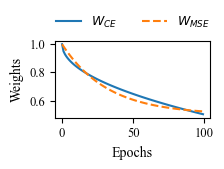

In [16]:
# epoch 等设置为全局变量，就不用每次都传参了
epochs = np.arange(100)
weight_ce = 1 - 0.5 * np.sqrt(epochs / 100)
weight_mse = 0.5 + 0.5 * np.exp(-epochs / 32)

plt.figure(figsize=(2, 1), dpi=100)
plt.plot(epochs, weight_ce, "-", label="$W_{CE}$")
plt.plot(epochs, weight_mse, "--", label="$W_{MSE}$")
plt.legend(
    ncol=2,
    loc="lower center",
    bbox_to_anchor=(0.50, 1.0),
)
plt.xlabel("Epochs")
plt.ylabel("Weights")
plt.savefig("weights.png", dpi=600, bbox_inches="tight")

In [17]:
weight_ce.shape

(100,)

In [18]:
def train_model(
    tra_ds,
    tes_ds,
    models,
    epoch_num=100,
    steps_per_epoch=10,
    val_steps_per_epoch=1,
    info=None,
):
    """从随机初始化的模型开始训练，直到模型收敛"""
    train_model_start_time = time.time()
    print("train_model 开始了", "!" * 100)
    tra_ds_iter, tes_ds_iter = iter(tra_ds), iter(tes_ds)

    assert epoch_num <= len(weight_ce)

    tra_tes_metric_logs = []
    for epoch in range(epoch_num):
        epoch_start_time = time.time()
        reset_train_metrics()  # 重置多个metric的观测器
        reset_test_metrics()  # 重置多个metric的观测器

        """---------Training------------------"""
        for step in range(steps_per_epoch):
            bX, bY = next(tra_ds_iter)
            models = train_step(
                X=bX,
                Y=bY,
                models=models,
                w_ce=weight_ce[epoch],
                w_mse=weight_mse[epoch],
            )

        """----------Testing-------------------"""
        for step in range(val_steps_per_epoch):
            bX, bY = next(tes_ds_iter)
            test_step(X=bX, Y=bY, models=models)  # 对验证集的测试

        """----------Metrics-------------------"""
        tra_metrics = get_train_metrics_result()
        tes_metrics = get_test_metrics_result()
        tra_tes_metric_logs.append(tra_metrics + tes_metrics)

        """----------Print-------------------"""
        if epoch % 10 == 0 or epoch + 1 == epoch_num:
            #         if epoch%q==0 :
            cinfo = "\t traN={}, \ttesN={}, \t w_ce={:.2f}, \t w_mse={:.2f}".format(
                steps_per_epoch,
                val_steps_per_epoch,
                weight_ce[epoch],
                weight_mse[epoch],
            )
            if info is not None:
                print(info, cinfo)
            print_log(tra_metrics, True)
            print_log(tes_metrics, False)
            print(
                "Epoch:{:4d}, \t\t Epoch time: {:>8.2f}\n".format(
                    epoch, time.time() - epoch_start_time
                )
            )

    tra_tes_metric_logs = np.array(tra_tes_metric_logs)  # [max_epoch,  4]
    print("Train_model time: {:>8.2f}".format(time.time() - train_model_start_time))
    print("train_model 结束了", "!" * 100)
    return models, tra_tes_metric_logs


(traXs, tesXs, traYs, tesYs), (tra_ds, tes_ds), CLS_NUM = get_batch_from_path(
    file_type="png",
    strides=5,
    train_rate=0.5,
    seed=19960103,
)
temp_models = get_model(
    FEM_name="AET",
    CLS_NUM=CLS_NUM,
)

models, tra_tes_metric_logs = train_model(
    tra_ds,
    tes_ds,
    temp_models,
    epoch_num=100,
    steps_per_epoch=1,
    val_steps_per_epoch=1,
    info=None,
)

Train number =   640, Test number =   640
Counter({0: 80, 2: 80, 6: 80, 7: 80, 1: 80, 5: 80, 4: 80, 3: 80}) Counter({6: 80, 0: 80, 3: 80, 4: 80, 1: 80, 7: 80, 2: 80, 5: 80}) 1.0
traXs.shape,  traYs.shape, traYs[:10]		(640, 256, 64)	(640,)	[0 2 6 7 1 1 5 4 0 3]
tesXs.shape,  tesYs.shape, tesYs[:10]		(640, 256, 64)	(640,)	[6 0 3 4 6 4 1 7 2 7]
tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10]	(64, 256, 64)	(64,)	[5 5 1 6 7 1 0 1 4 0]
tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10]	(64, 256, 64)	(64,)	[3 6 4 1 4 5 3 3 0 2]
Dataset OK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 


GGGGGGGGGGGGGGGet Modellllllllllll 
 FEM_name=AET,   CLS_NUM=10,  need_BA=None
    

                  # 输入 2D信号 的参数
                  cwt_data                	 = 	 True,
                  cwt_shape               	 = 	 (256, 64),
                  cwt_patch               	 = 	 (8, 8),
                  cwt_embedding_way       	 = 	 Linear,
                  
                  # 输入 1D信号 的参数
                  sig_data           

# 训练

## Weights、LOG、RESULT

In [19]:
def save_weights_and_log():
    FEM, HCM = models

    """存储模型权重"""
    item = save_path + get_date() + dta_R_date
    for model in models:
        model_save_path = item + model.name + ".h5"
        model.save_weights(model_save_path)
        model.load_weights(model_save_path)

    """训练日志"""
    metric_names = ["CE", "MSE", "Accuracy(%)", "F1(%)", "Precision(%)", "Recall(%)"]
    columns = ["tra " + i for i in metric_names] + ["val " + i for i in metric_names]

    log_df = pd.DataFrame(tra_tes_metric_logs, columns=columns)
    log_path = save_path + get_date() + dta_R_date + "LOG.csv"
    log_df.to_csv(log_path, index=False)

    print("-" * 100, "\n训练的最后10Epoch的平均Metrics.")
    print(log_df.iloc[-10:,].describe().loc[["mean", "50%"]])
    print("训练的最后10Epoch的平均Metrics.\n", "-" * 100)
    return log_df, log_path


try:
    log_df, log_path = save_weights_and_log()
except:
    print("error")


def save_test_result(item=""):
    """最终的测试结果"""
    tra_CE = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)(
        y_true=traYs, y_pred=traPs
    )
    tra_AC = (
        tf.keras.metrics.SparseCategoricalAccuracy()(y_true=traYs, y_pred=traPs) * 100
    )
    traF1, traP, traR = get_macro_F1(y_true=traYs, y_pred=traPargM, cls_num=CLS_NUM)

    tes_CE = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)(
        y_true=tesYs, y_pred=tesPs
    )
    tes_AC = (
        tf.keras.metrics.SparseCategoricalAccuracy()(y_true=tesYs, y_pred=tesPs) * 100
    )
    tesF1, tesP, tesR = get_macro_F1(y_true=tesYs, y_pred=tesPargM, cls_num=CLS_NUM)

    final_result = [
        [
            item.numpy()
            for item in [
                tra_CE,
                tra_AC,
                traF1,
                traP,
                traR,
                tes_CE,
                tes_AC,
                tesF1,
                tesP,
                tesR,
            ]
        ]
    ]
    result_names = [
        "tra CE",
        "tra AC",
        "tra F1",
        "tra P",
        "tra R",
        "tes CE",
        "tes AC",
        "tes F1",
        "tes P",
        "tes R",
    ]

    final_result_df = pd.DataFrame(data=final_result, columns=result_names)

    path = save_path + get_date() + dta_R_date + item + "Final_Result.csv"
    final_result_df.to_csv(path, index=False)

    print("=" * 100, "\n在训练集和测试集上的最终测试结果.\n")
    print(final_result_df)
    print("在训练集和测试集上的最终测试结果.\n", "=" * 100)

    return final_result_df

---------------------------------------------------------------------------------------------------- 
训练的最后10Epoch的平均Metrics.
        tra CE  tra MSE  tra Accuracy(%)  tra F1(%)  tra Precision(%)  \
mean  2.112446      0.0          12.1875   8.167162          9.357184   
50%   2.117488      0.0          10.9375   7.626044          7.220238   

      tra Recall(%)    val CE  val MSE  val Accuracy(%)  val F1(%)  \
mean      11.391819  2.083997      0.0         14.53125   2.936658   
50%        9.558442  2.087927      0.0         14.84375   2.822599   

      val Precision(%)  val Recall(%)  
mean          1.849571      10.272727  
50%           1.643689      10.000000  
训练的最后10Epoch的平均Metrics.
 ----------------------------------------------------------------------------------------------------


## Metrics curve

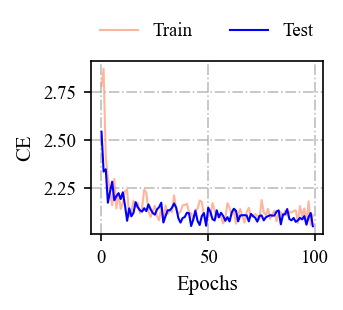

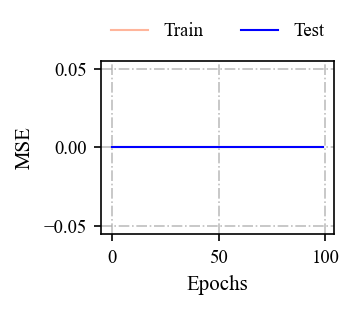

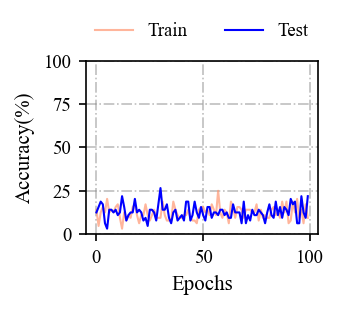

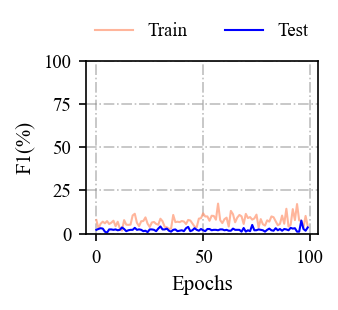

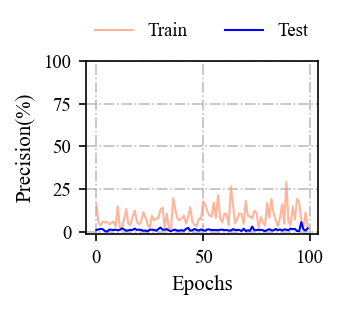

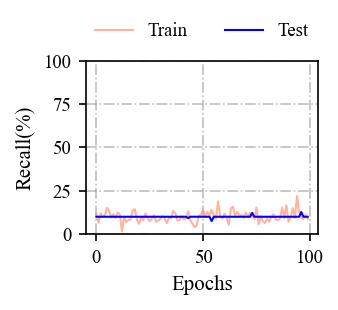

In [20]:
def plot_metrics_curve(df, metrics, need_tra=True, need_save=True):
    """画出n个metrics的曲线图，metrics必须是list
    metric_names = ['SHCE','SHAC',  'THCE','THAC',  'SSC','SDC',  'DCE','DAC','DCS']
    """
    assert isinstance(metrics, list)
    assert len(metrics) in [1, 2]
    if "CE" in str(metrics):
        assert len(metrics) == 1

    plt.subplots(
        figsize=[2, 1.5],
    )
    colors = [
        "#FF9671",
        "b",
        "#008E9B",
        "r",
    ]
    for mi, metric in enumerate(metrics):
        if need_tra:
            plt.plot(
                df["tra " + metric],
                label="Train",
                linewidth=1,
                color=colors[mi * 2 + 0],
                alpha=0.7,
            )  # 训练曲线
        plt.plot(
            df["val " + metric],
            label="Test",
            linewidth=1,
            color=colors[mi * 2 + 1],
            alpha=1.0,
        )  # 验证曲线

    if need_tra:
        plt.legend(
            ncol=2,
            loc="lower center",
            bbox_to_anchor=(0.50, 1.02),  # legend的坐标原点与坐标原点的相对坐标
        )

    plt.grid(True, linestyle="--", which="major", color="grey", alpha=0.2)
    plt.grid(True, linestyle="-.", which="major", color="grey", alpha=0.5)

    if "E" in str(metrics):
        #         plt.yticks(ticks=np.arange(0, 2,    4)  )
        plt.xlabel(xlabel="Epochs")
        plt.ylabel(ylabel=metrics[0])
    else:
        plt.yticks(np.arange(0, 105, 25))
        plt.xlabel(xlabel="Epochs")
        plt.ylabel(ylabel=metrics[0])

    if need_save:
        path = save_path + get_date() + dta_R_date + str(metrics)
        plt.savefig(path + ".png", bbox_inches="tight")
    #         plt.savefig(path + '.svg',  bbox_inches ='tight')
    plt.show()
    return


try:
    plot_metrics_curve(df=log_df, metrics=["CE"])
    plot_metrics_curve(df=log_df, metrics=["MSE"])
    plot_metrics_curve(df=log_df, metrics=["Accuracy(%)"])
    plot_metrics_curve(df=log_df, metrics=["F1(%)"])
    plot_metrics_curve(df=log_df, metrics=["Precision(%)"])
    plot_metrics_curve(df=log_df, metrics=["Recall(%)"])
except:
    print("没数据")

## Feature、Logits、Attention weights

In [21]:
def get_features_AW_and_P_of_one_batch(models, bXs):
    """直接把所有样本都送进FEM来提特征时，数据量太大会内存溢出,
    由于 AW 太占内存了，所以只存储 1 batch 的AW，并返回
    """
    """ 输入一个batch的数据，返回一个batch的features，AW，P
    Xs.shape=【bs，pos, depth】，"""
    assert len(bXs) <= 100  # 输入数据太多时，可能会内存不够
    #     print(type(bXs), bXs.shape)
    FEM, HCM = models

    if FEM.name in ["ST", "NET", "AET"]:
        bFs, bAWs = FEM(bXs, training=False, need_w=True)
        if FEM.name == "AET":
            bFs = bFs
    else:
        bFs = FEM(bXs, training=False)  # 提取的 特征          (bs, dim)
        bAWs = {"No Data": np.zeros((1))}  # 用于占位

    bPs = HCM(
        bFs, training=False
    )  # 预测 健康状态        (bs, 256，256，4)  feat6，feat7，out8
    # print(bFs.shape, bPs.shape, BAWs.keys())
    return bFs, bPs, bAWs


def get_whole_FP(models, Xs, bs=100, need_save=True):
    batch_num = int(np.ceil(len(Xs) / bs))
    print(
        "输入了{:4d}样本,\t 测试时每{:4d}个样本一个batch @ ".format(len(Xs), bs),
        batch_num,
    )
    all_Fs = []
    all_Ps = []
    for i in range(batch_num):
        bXs = Xs[i * bs : (i + 1) * bs]
        bFs, bPs, bAWs = get_features_AW_and_P_of_one_batch(
            models=models,
            bXs=bXs,
        )
        all_Fs.append(bFs)
        all_Ps.append(bPs)
    print("Last batch:", bFs.shape, bPs.shape)
    all_Fs = tf.concat(all_Fs, axis=0).numpy()
    all_Ps = tf.concat(all_Ps, axis=0).numpy()
    all_P_after_arg_max = tf.argmax(all_Ps, axis=-1).numpy()

    ### 保存成CSV
    if need_save:
        Fs_df_columns = ["f_{}".format(i) for i in range(all_Fs.shape[-1])]
        Fs_df = pd.DataFrame(data=all_Fs, columns=Fs_df_columns)
        path = save_path + get_date() + dta_R_date + "Features.csv"
        Fs_df.to_csv(path, index=False)

        Ps_df_columns = ["p_{}".format(i) for i in range(all_Ps.shape[-1])]
        Fs_df = pd.DataFrame(data=all_Ps, columns=Ps_df_columns)
        path = save_path + get_date() + dta_R_date + "Logits.csv"
        Fs_df.to_csv(path, index=False)

    return all_Fs, all_Ps, all_P_after_arg_max


(traXs, tesXs, traYs, tesYs), (tra_ds, tes_ds), CLS_NUM = get_batch_from_path(
    file_type="png",
    strides=5,
    train_rate=0.2,
    seed=19960103,
)

bX, bY = next(iter(tra_ds))
temp_models = get_model(
    FEM_name="AET",
    CLS_NUM=CLS_NUM,
)


bFs, bPs, bAWs = get_features_AW_and_P_of_one_batch(
    models=temp_models,
    bXs=bX,
)
print(bFs.shape, bPs.shape, bAWs.keys())


traFs, traPs, traPargM = get_whole_FP(models=temp_models, Xs=traXs, need_save=False)
tesFs, tesPs, tesPargM = get_whole_FP(
    models=temp_models, Xs=tesXs, need_save=True
)  # 仅保存测试集上的结果

print(
    "traFs.shape, traPs.shape, traPargM.shape", traFs.shape, traPs.shape, traPargM.shape
)
print(
    "tesFs.shape, tesPs.shape, traPargM.shape", tesFs.shape, tesPs.shape, traPargM.shape
)

Train number =   256, Test number =  1024
Counter({6: 32, 2: 32, 4: 32, 0: 32, 5: 32, 1: 32, 3: 32, 7: 32}) Counter({6: 128, 0: 128, 5: 128, 7: 128, 3: 128, 2: 128, 4: 128, 1: 128}) 4.0
traXs.shape,  traYs.shape, traYs[:10]		(256, 256, 64)	(256,)	[6 2 4 0 5 0 1 4 0 4]
tesXs.shape,  tesYs.shape, tesYs[:10]		(1024, 256, 64)	(1024,)	[6 0 5 7 0 3 2 4 0 0]
tra_bX.shape, tra_bY.shape, tra_bY.numpy()[:10]	(64, 256, 64)	(64,)	[3 0 6 7 2 1 5 4 0 3]
tes_bX.shape, tes_bY.shape, tes_bY.numpy()[:10]	(64, 256, 64)	(64,)	[2 7 2 3 2 0 5 4 3 0]
Dataset OK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 


GGGGGGGGGGGGGGGet Modellllllllllll 
 FEM_name=AET,   CLS_NUM=10,  need_BA=None
    

                  # 输入 2D信号 的参数
                  cwt_data                	 = 	 True,
                  cwt_shape               	 = 	 (256, 64),
                  cwt_patch               	 = 	 (8, 8),
                  cwt_embedding_way       	 = 	 Linear,
                  
                  # 输入 1D信号 的参数
                  sig_data 

## Confusion matrix

plot_confusion_matrix 入口： 	 (256,) (256,)


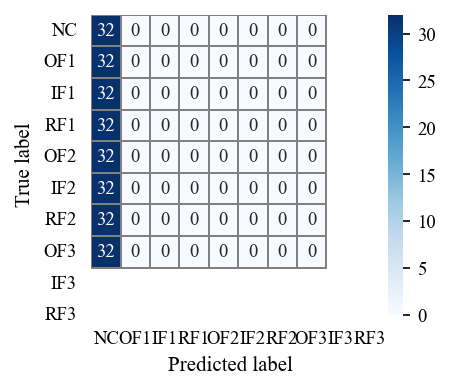

plot_confusion_matrix 入口： 	 (1024,) (1024,)


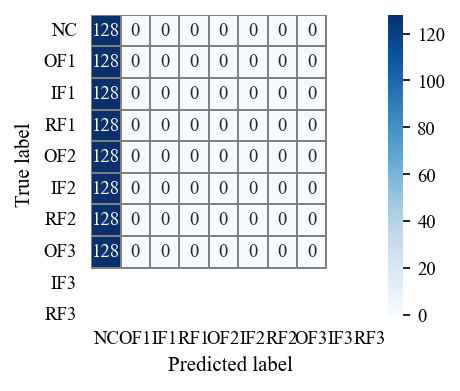

In [22]:
def plot_confusion_matrix(y_true, y_pred, class_num, item=None, need_save=True):
    print("plot_confusion_matrix 入口： \t", y_true.shape, y_pred.shape)
    assert np.max(y_true) < class_num
    assert np.max(y_pred) < class_num

    cm = confusion_matrix(y_true, y_pred)
    #     print(cm)

    tick_names = Health_status
    tick_names = tick_names[:class_num]
    plt.figure(figsize=(3.0, 2.6))
    sns.heatmap(
        data=cm,
        fmt=".0f",
        annot=True,
        annot_kws={"size": 9},
        cmap="Blues",  # Greys  Blues Greens Reds
        linewidths=0.1,
        linecolor="gray",
    )

    xlocations = np.array(range(class_num)) + 0.5
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    plt.xticks(
        ticks=np.arange(class_num) + 0.5,
        labels=tick_names,
        rotation=0,
    )
    plt.yticks(
        ticks=np.arange(class_num) + 0.5,
        labels=tick_names,
        rotation=0,
    )

    plt.gca().xaxis.set_ticks_position("none")  # 屏蔽掉坐标轴的刻度线
    plt.gca().yaxis.set_ticks_position("none")
    if need_save:
        path = save_path + get_date() + dta_R_date + item + "Confusion_Matrix"
        #         plt.savefig(path  + '.svg', bbox_inches ='tight')
        plt.savefig(path + ".png", bbox_inches="tight")
    plt.show()
    return


# print('-'*100, target_Y.shape, target_hc_label_P.shape, target_Y, target_hc_label_P)
plot_confusion_matrix(
    y_true=traYs, y_pred=traPargM, class_num=CLS_NUM, item="tra", need_save=True
)

plot_confusion_matrix(
    y_true=tesYs, y_pred=tesPargM, class_num=CLS_NUM, item="tes", need_save=True
)